# Objective Functions

* https://github.com/JohnLangford/vowpal_wabbit/wiki/Loss-functions

| Loss | Minimizer | Example |
|:-----|:----------|:--------|
| MSE, MAE, RMSLE  | Expectation (mean) | Regression (Expected return on stock) |
| Logistic, Entropy, KL-Divergence | Probability | Classification (Probability of click on ad) |
| Hinge | 0 ~ 1 approximation | Classification (Is the digit a 7?) |
| Poisson | Counts (Log Mean) | Regression (Number of call events to call center) |

In [4]:
%pylab inline
import numpy as np
from sklearn import metrics
from sklearn.preprocessing import minmax_scale
from scipy import stats
from scipy.spatial.distance import cosine as cosine_distantce

# Pytorch
import torch
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable

Populating the interactive namespace from numpy and matplotlib


## Data

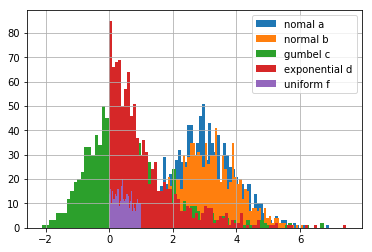

In [5]:
a = np.random.normal(loc=3, size=1000)
b = np.random.normal(loc=3, size=1000)
c = np.random.gumbel(size=1000)
d = np.random.exponential(size=1000)
f = np.random.uniform(size=1000)

hist(a, bins=80, label='nomal a')
hist(b, bins=80, label='normal b')
hist(c, bins=80, label='gumbel c')
hist(d, bins=80, label='exponential d')
hist(f, bins=80, label='uniform f')

grid()
legend()

In [65]:
def compare_distributions(func):
    print('normal_a, normal_a\t:', func(a, a))
    print('normal_a, normal_b\t:', func(a, b))
    print('normal_a, gumbel  \t:', func(a, c))
    print('normal_a, exponent\t:', func(a, d))
    print('normal_a, uniform \t:', func(a, f))
    
def display_graph(func, name='loss', start=-2, end=2, y=0):
    y = np.array([y])
    predictions = np.arange(start, end + 0.001, 0.001)
    predictions[predictions == 0] = 1e-18
    
    r = [func(y, np.array([p])) if p != 0 else 1e-18 for p in predictions]
    
    title(name + f' y={y[0]}')
    xlabel(f'prediction value {start} ~ {end}')
    ylabel(f'{name} value')
    plot(predictions, r)
    grid()

## Mean Squared Error (MSE)

* http://mccormickml.com/2014/03/04/gradient-descent-derivation/

regression에서 대체로 많이 사용되는 cost function중의 하나입니다.<br>
단점은 square 를 사용하기 때문에 cost이 지나치게 커져서 unstable 한 모델에 적용시 oscillation 현상이 일어날수 있습니다.

$$ J(\theta) = \frac{1}{N} \sum^{N}_{i=1} \left( h_{\theta}(x^{(i)}) - y^{(i)}  \right)^2 $$

* $ J $ : cost function
* $ \theta $ : parameters (weights)
* N : training data의 갯수
* $ x^{(i)} $ : $ i^{th} $의 training input vector
* $ y^{(i)} $ : $ i^{th} $의 class label
* $ h_{\theta} \left( x^{(i)} \right) $ : $ \theta $를 사용하여 나온 $ i^{th} $ data에 대한 prediction


#### Partial derivative of the weights

$$ \begin{eqnarray} \\
\frac{\partial}{\partial\theta} J(\theta) &=& \frac{\partial}{\partial \theta} \left( \frac{1}{N} \sum^N_{i=1} \left( h_{\theta}(x^{(i)}) - y^{(i)} \right)^2 \right) & [0.1] \\
&=&  \frac{2}{N} \sum^{N}_{i=0} \left( h_{\theta} (x^{(i)}) - y^{(i)} \right) \frac{\partial}{\partial \theta} \left( h_{\theta}(x^{(i)}) - y^{(i)}  \right) & [0.2] \\
&=& \frac{2}{N} \sum^{N}_{i=0} \left( h_{\theta} (x^{(i)}) - y^{(i)} \right) \frac{\partial}{\partial \theta} \left( \theta^T \cdot x^{(i)} + b - y^{(i)}  \right) & [0.3]\\
&=& \frac{2}{N} \sum^{N}_{i=0} \left( h_{\theta} (x^{(i)}) - y^{(i)} \right) \odot x^{(i)} & [0.4]\\
\end{eqnarray} $$ 

0.3 에서 0.4를 넘어갈때 $ \theta $를 제외하고는 모두 상수이기 때문에 ($ b, x, y$)값 모두 0이 됩니다.

#### Partial derivative of the bias variable

$$ \begin{eqnarray} \\
\frac{\partial}{\partial b} J(\theta) &=& \frac{\partial}{\partial b} \left( \frac{1}{N} \sum^N_{i=1} \left( h_{\theta}(x^{(i)}) - y^{(i)} \right)^2 \right) & [0.1] \\
&=&  \frac{2}{N} \sum^{N}_{i=0} \left( h_{\theta} (x^{(i)}) - y^{(i)} \right) \frac{\partial}{\partial b} \left( h_{\theta}(x^{(i)}) - y^{(i)}  \right) & [0.2] \\
&=& \frac{2}{N} \sum^{N}_{i=0} \left( h_{\theta} (x^{(i)}) - y^{(i)} \right) \frac{\partial}{\partial b} \left( \theta^T \cdot x^{(i)} + b - y^{(i)}  \right) & [0.3]\\
&=& \frac{2}{N} \sum^{N}_{i=0} \left( h_{\theta} (x^{(i)}) - y^{(i)} \right) & [0.4]\\
\end{eqnarray} $$ 


In [6]:
p = np.array([0.1, 0.1, 0.05, 0.6, 0.3], dtype=np.float32)
y = np.array([0, 0, 0, 1, 0], dtype=np.float32)

def mean_squared_error(y, p):
    return ((y - p)**2).mean()

mean_squared_error(y, p)

0.054499995

In [5]:
metrics.mean_squared_error(y, p)

0.054499995

In [6]:
compare_distributions(mean_squared_error)

normal_a, normal_a	: 0.0
normal_a, normal_b	: 1.94313775689
normal_a, gumbel  	: 8.34935806101
normal_a, exponent	: 5.89498613265
normal_a, uniform 	: 7.26803261167


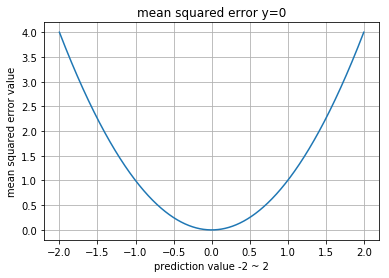

In [66]:
display_graph(metrics.mean_squared_error, 'mean squared error')

## Mean Absolute Error (MAE)

MSE가 large error를 낸다면, MAE의 경우는 상대적으로 작은 에러들을 만듭니다.<br>
하지만 수학적으로 absolute는 많은 연산량을 필요로 합니다. 

$$ J(\theta) = \frac{1}{N} \sum^{N}_{i=1} \left| h_{\theta}(x^{(i)}) - y^{(i)}  \right| $$

In [8]:
def mean_abolute_error(y, p):
    return np.abs(y-p).mean()

mean_abolute_error(y, p)

0.19

In [9]:
metrics.mean_absolute_error(y, p)

0.19

In [10]:
# Scipy도 동일함
compare_distributions(mean_abolute_error)

normal_a, normal_a	: 0.0
normal_a, normal_b	: 1.11369204926
normal_a, gumbel  	: 2.57300947501
normal_a, exponent	: 2.13340783974
normal_a, uniform 	: 2.48578624644


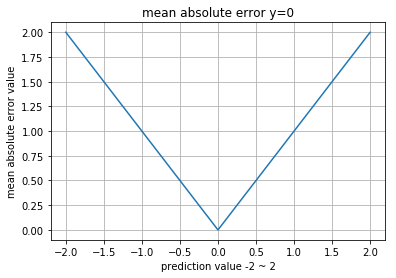

In [67]:
display_graph(metrics.mean_absolute_error, 'mean absolute error')

## Root Mean Squared Logarithmic Error (RMSLE)

$ p $ 그리고 $ a $ 는 확률.. 즉 0에서 1사이이의 값이 들어가야 합니다.

$$ \epsilon = \sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 } $$

In [19]:
def mean_squared_logarithmic_error(y, p):
    try:
        l = lambda x: np.nan_to_num(np.log(x + 1))
        return np.sqrt(((l(p) - l(y))**2).mean())
    except Exception as e:
        print(p + 1)
        raise e

mean_squared_logarithmic_error(y, p)

0.16683918

In [13]:
compare_distributions(mean_squared_logarithmic_error)

normal_a, normal_a	: 0.0
normal_a, normal_b	: 0.398201741497
normal_a, gumbel  	: 1.40502234456
normal_a, exponent	: 0.890724788695
normal_a, uniform 	: 1.02307079398


/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


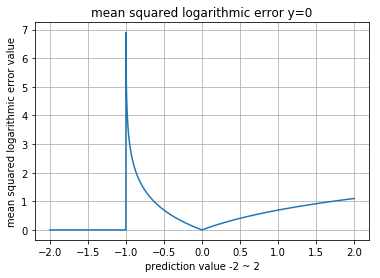

In [68]:
display_graph(mean_squared_logarithmic_error, 'mean squared logarithmic error')

## Binary Cross Entropy (a.k.a Logarithmic Loss)

* https://www.kaggle.com/wiki/LogarithmicLoss

$$ \text{logloss} = -\frac{1}{N} \sum^{N}_{i=1} \left( y^{(i)} \cdot \log(p_i) + (1 - y) \cdot \log(1- p_i) )  \right) $$



#### Numpy

In [34]:
y_true = np.array([0, 0, 0, 1, 0], dtype=np.float64)
y_pred = np.array([0.1, 0.1, 0.05, 0.6, 0.3], dtype=np.float64)

def binary_cross_entropy(y_true, y_pred):
    return -(y_true * np.log(y_pred) + (1-y_true) * np.log(1-y_pred)).mean()

binary_cross_entropy(y_true, y_pred)

0.22590297868158524

#### Scipy

In [26]:
# Scipy와 동일함
metrics.log_loss(y_true, y_pred)

0.22590297868158524

#### Pytorch

F.binary_cross_entropy 와 nn.BCELoss 의 결과값은 동일합니다.

In [53]:
y_torch_pred = Variable(torch.DoubleTensor(y_pred))
y_torch_true = Variable(torch.DoubleTensor(y_true))

torch_crossentropy = nn.BCELoss()
torch_crossentropy(y_torch_pred, y_torch_true).data.numpy()

array([ 0.22590298])

#### Display

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """


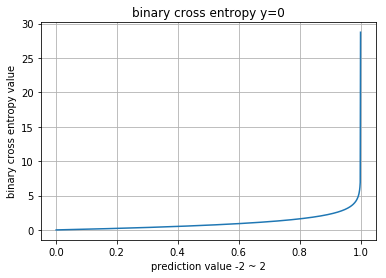

In [69]:
display_graph(binary_cross_entropy, 'binary cross entropy')

## Cross Entropy

* https://rdipietro.github.io/friendly-intro-to-cross-entropy-loss/

$$ H(y, \hat{y}) = - \sum_i y^{(i)} \log \hat{y}^{(i)} $$

#### Partial derivative of the weights

$$ \begin{eqnarray}
H(y, \hat{y}) &=& -\frac{\partial}{\partial \theta} \sum^N_{i=1} y^{(i)} \log \hat{y}^{(i)} \\
&=& - \sum^N_{i=1} \frac{y^{(i)}}{ \frac{\partial}{\partial \theta} \hat{y}^{(i)}} \\
&=& - \sum^N_{i=1} \frac{y^{(i)}}{ \frac{\partial}{\partial \theta} \left( \theta^{T} \cdot x^{(i)} + b \right) } \\
&=& - \sum^N_{i=1} \frac{y^{(i)}}{x^{(i)}}
\end{eqnarray} $$

#### Partial derivative of the bias 

$$ \begin{eqnarray}
H(y, \hat{y}) &=& -\frac{\partial}{\partial b} \sum^N_{i=1} y^{(i)} \log \hat{y}^{(i)} \\
&=& - \sum^N_{i=1} \frac{y^{(i)}}{ \frac{\partial}{\partial b} \hat{y}^{(i)}} \\
&=& - \sum^N_{i=1} \frac{y^{(i)}}{ \frac{\partial}{\partial b} \left( \theta^{T} \cdot x^{(i)} + b \right) } \\
&=& - \sum^N_{i=1} y^{(i)}
\end{eqnarray} $$

#### Numpy

In [46]:
y_true = np.array([0, 0, 0, 1, 0], dtype=np.float32)
y_pred = np.array([0.1, 0.1, 0.05, 0.6, 0.3], dtype=np.float32)

def cross_entropy(y_true, y_pred):
    return -(y_true * np.log(y_pred)).sum()

cross_entropy(y_true, y_pred)

0.51082557

#### Pytorch - cross entropy

Pytorch의 cross entropy는 일반적인 cross entropy와 전혀 다릅니다.

$$ \hat{y}_{class} + \log\left( \sum_j e^{\hat{y}_j} \right) $$

In [45]:
y_true = np.array([3, 1], dtype=np.int64)
y_pred = np.array([[0.1, 0.1, 0.05, 0.6, 0.3], 
                   [0, 0.9, 0.05, 0.001, 0.3]], dtype=np.float64)


def torch_cross_entropy(y_pred, labels):
    N = y_pred.shape[0]
    return (-y_pred[range(N), labels] + np.log(np.sum(np.exp(y_pred), axis=1))).mean()
    
torch_cross_entropy(y_pred, y_true)

1.1437464478328658

In [229]:
y_true = np.array([3], dtype=np.int64)
y_pred = np.array([[0.1, 0.1, 0.05, 0.6, 0.3]], dtype=np.float32)

def torch_cross_entropy(y_pred, labels):
    N = y_pred.shape[0]
    return (-y_pred[range(N), labels] + np.log(np.sum(np.exp(y_pred), axis=1))).mean()
    

torch_cross_entropy(y_pred, y_true)

1.2615328

In [230]:
y_true = np.array([3], dtype=np.int64)
y_pred = np.array([[0.1, 0.1, 0.05, 0.6, 0.3]], dtype=np.float32)

y_torch_true = Variable(torch.LongTensor(y_true))
y_torch_pred = Variable(torch.FloatTensor(y_pred))

torch_cross_entropy = nn.CrossEntropyLoss()
torch_cross_entropy(y_torch_pred, y_torch_true).data.numpy()

array([ 1.26153278], dtype=float32)

#### Pytorch - Custom Cross Entropy

Pytorch에서 제공하는 nn.CrossEntropyLoss는 기존 cross-entropy loss와 다름으로, 정확하게 동일한 코드를 사용시 만들어줘야 합니다.

In [267]:
def torch_custom_cross_entropy(y_true, y_pred):
    return -torch.sum(y_true * torch.log(y_pred))
    
y_true = np.array([0, 0, 0, 1, 0], dtype=np.float32)
y_pred = np.array([0.1, 0.1, 0.05, 0.6, 0.3], dtype=np.float32)

y_torch_true = Variable(torch.FloatTensor(y_true))
y_torch_pred = Variable(torch.FloatTensor(y_pred))

torch_custom_cross_entropy(y_torch_true, y_torch_pred).data.numpy()

array([ 0.51082557], dtype=float32)

#### Display

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """


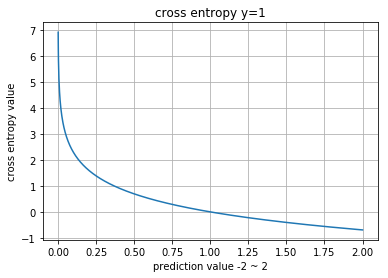

In [70]:
display_graph(cross_entropy, 'cross entropy', y=1)

## Hinge Loss

logistic과 마찬가지로 binary classification에 사용됩니다.<br>
라이브러리 사용하면 알아서 처리되지만, 기본적으로 labels은 -1 또는 1이어야 합니다. 

$$ J(\theta) = max(0,\ 1 - y * f(x)) $$

In [58]:
p = np.array([0.1, 0.1, 0.05, 0.6, 0.3], dtype=np.float32)
y = np.array([-1, -1, -1, 1, -1], dtype=np.float32)

def hinge_loss(y, p):
    l = 1-(y*p)
    l[l<=0] = 0
    return l.mean()

hinge_loss(y, p)

0.98999995

In [21]:
metrics.hinge_loss(y, p)

0.98999999836087227

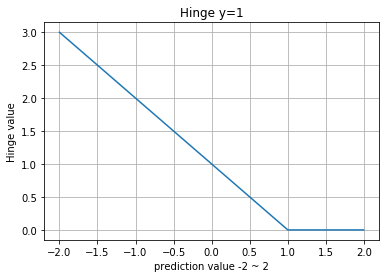

In [72]:
display_graph(hinge_loss, 'Hinge', y=1)

## KL-Divergence

$ p $ 그리고 $ q $ 는 확률분포 (0에서 1사이의 값) 이어야 합니다.

$$ D_{KL}\left(p(x), q(x)\right) = \sum_{x \in X} p(x) \ln\frac{p(x)}{q(x)} $$

> 참고로.. Scipy.stats.entropy(a, b)를 사용하면 KL-Divergence를 사용하는 것과 마찬가지인데.. <br>
> 내부적으로 nan등 처리가 안되어 있어서 값이 안나옴

In [74]:
def kl_divergence(y, p):
    return np.sum(y * np.nan_to_num(np.log(y/p)), axis=0)

compare_distributions(kl_divergence)

normal_a, normal_a	: 0.0
normal_a, normal_b	: 368.575575809
normal_a, gumbel  	: 2596.54562019
normal_a, exponent	: 4806.30679955
normal_a, uniform 	: 6476.72186957


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


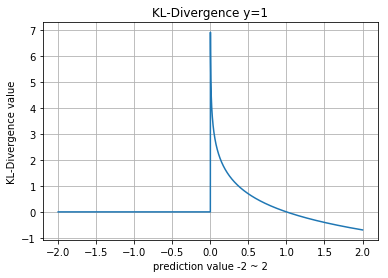

In [77]:
display_graph(kl_divergence, 'KL-Divergence', y=1)

## Cosine Proximity

* https://en.wikipedia.org/wiki/Cosine_similarity

$$ \text{similarity} = cos(\theta) = \frac{A \cdot B}{ \| A \|_2 \| B \|_2}  $$

In [79]:
def cosine_proximity(a, b):
    norm2 = lambda x: np.sqrt((x**2).sum())
    return 1 - (a * b).sum() / (norm2(a) * norm2(b))

cosine_proximity(np.array([0.3, 0.4]), np.array([1, 2]))

0.016130089900092459

In [26]:
compare_distributions(cosine_distantce)

normal_a, normal_a	: 2.22044604925e-16
normal_a, normal_b	: 0.0998470768358
normal_a, gumbel  	: 0.604350409384
normal_a, exponent	: 0.331605768793
normal_a, uniform 	: 0.188153360738


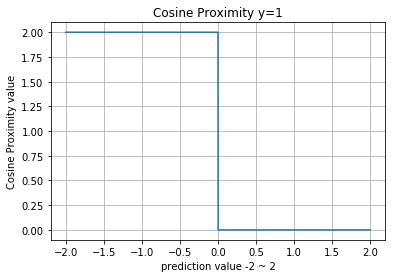

In [81]:
display_graph(cosine_proximity, 'Cosine Proximity', y=1)

## Poisson

* https://github.com/fchollet/keras/pull/479/commits/149d0e8d1871a7864fc2d582d6ce650512de371c

In [84]:
p = np.array([0.1, 0.1, 0.05, 0.6, 0.3], dtype=np.float32)
y = np.array([0, 0, 0, 1, 0], dtype=np.float32)

def poisson_loss(y, p):
    return (p - y * np.log(p)).mean()

poisson_loss(y, p)

0.33216509

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """


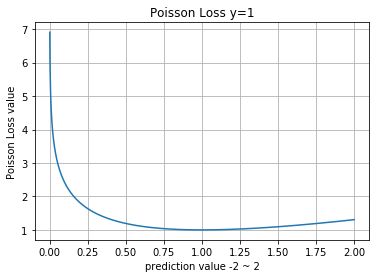

In [87]:
display_graph(poisson_loss, 'Poisson Loss', y=1)